In [77]:
# 导入所需模块
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np
# plt显示彩色图片
def plt_show0(img):
#cv2与plt的图像通道不同：cv2为[b,g,r];plt为[r, g, b]
    b,g,r = cv2.split(img)
    img = cv2.merge([r, g, b])
    plt.imshow(img)
    plt.show()
    
# plt显示灰度图片
def plt_show(img):
    plt.imshow(img,cmap='gray')
    plt.show()

# 图像去噪灰度处理
def gray_guss(image):
    image = cv2.GaussianBlur(image, (3, 3), 0)
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

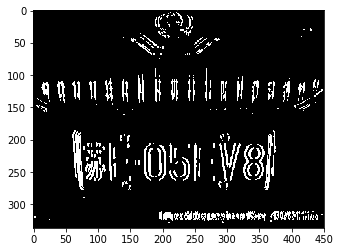

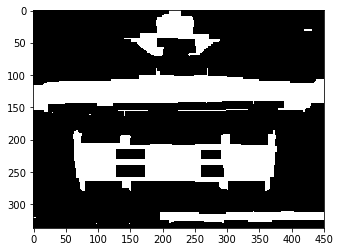

In [90]:
# 读取待检测图片
origin_image = cv2.imread('./img/car.jpg')
# 复制一张图片，在复制图上进行图像操作，保留原图
image = origin_image.copy()
# 图像去噪灰度处理
gray_image = gray_guss(image)

# x方向上的边缘检测（增强边缘信息）
Sobel_x = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
absX = cv2.convertScaleAbs(Sobel_x)
image = absX

# 图像阈值化操作——获得二值化图
ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)

# 显示灰度图像
plt_show(image)

# 形态学（从图像中提取对表达和描绘区域形状有意义的图像分量）——闭操作
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 10))
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX,iterations = 1)

# 显示灰度图像
plt_show(image)

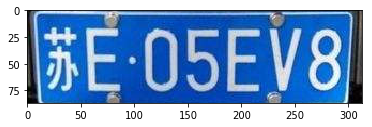

In [106]:
image = cv2.imread('./img/car.jpg')
gray_image = gray_guss(image)
Sobel_x = cv2.Sobel(gray_image, cv2.CV_16S, 1, 0)
absX = cv2.convertScaleAbs(Sobel_x)
image = absX
ret, image = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU)
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 5))
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernelX,iterations = 3)
kernelX = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
kernelY = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 19))
image = cv2.dilate(image, kernelX)
image = cv2.erode(image, kernelX)
image = cv2.erode(image, kernelY)
image = cv2.dilate(image, kernelY)
image = cv2.medianBlur(image, 15)
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for item in contours:
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    if (weight > (height * 3)) and (weight < (height * 4)):
        image = origin_image[y:y + height, x:x + weight]
        plt_show0(image)

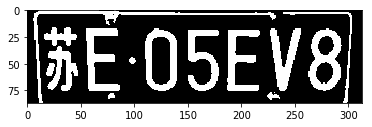

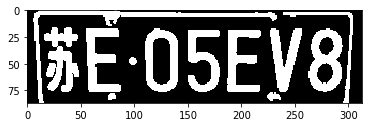

In [107]:
#车牌字符分割
# 图像去噪灰度处理
gray_image = gray_guss(image)
# 图像阈值化操作——获得二值化图   
ret, image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_OTSU)
plt_show(image)

#膨胀操作，使“苏”字膨胀为一个近似的整体，为分割做准备
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
image = cv2.dilate(image, kernel)
plt_show(image)

1
2
3
4
5
6
7
[[6, 0, 228, 87], [16, 17, 33, 60], [55, 18, 33, 59], [76, 78, 7, 6], [95, 44, 8, 8], [110, 18, 31, 59], [150, 19, 30, 58], [187, 19, 32, 58], [224, 77, 13, 8], [227, 18, 30, 59], [239, 3, 66, 84], [263, 18, 32, 59]]


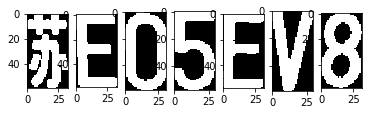

In [108]:
# 查找轮廓
contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
words = []
word_images = []
#对所有轮廓逐一操作
for item in contours:
    word = []
    rect = cv2.boundingRect(item)
    x = rect[0]
    y = rect[1]
    weight = rect[2]
    height = rect[3]
    word.append(x)
    word.append(y)
    word.append(weight)
    word.append(height)
    words.append(word)
# 排序，车牌号有顺序。words是一个嵌套列表
words = sorted(words,key=lambda s:s[0],reverse=False)
i = 0
#word中存放轮廓的起始点和宽高
for word in words:
    # 筛选字符的轮廓
    if (word[3] > (word[2] * 1.5)) and (word[3] < (word[2] * 3.5)) and (word[2] > 25):
        i = i+1
        splite_image = image[word[1]:word[1] + word[3], word[0]:word[0] + word[2]]
        word_images.append(splite_image)
        print(i)
print(words)

for i,j in enumerate(word_images):  
    plt.subplot(1,7,i+1)
    plt.imshow(word_images[i],cmap='gray')
plt.show()

In [109]:
#模版匹配
# 准备模板(template[0-9]为数字模板；)
template = ['0','1','2','3','4','5','6','7','8','9',
            'A','B','C','D','E','F','G','H','J','K','L','M','N','P','Q','R','S','T','U','V','W','X','Y','Z',
            '藏','川','鄂','甘','赣','贵','桂','黑','沪','吉','冀','津','晋','京','辽','鲁','蒙','闽','宁',
            '青','琼','陕','苏','皖','湘','新','渝','豫','粤','云','浙']

# 读取一个文件夹下的所有图片，输入参数是文件名，返回模板文件地址列表
def read_directory(directory_name):
    referImg_list = []
    for filename in os.listdir(directory_name):
        referImg_list.append(directory_name + "/" + filename)
    return referImg_list

# 获得中文模板列表（只匹配车牌的第一个字符）
def get_chinese_words_list():
    chinese_words_list = []
    for i in range(34,64):
        #将模板存放在字典中
        c_word = read_directory('./refer1/'+ template[i])
        chinese_words_list.append(c_word)
    return chinese_words_list
chinese_words_list = get_chinese_words_list()


# 获得英文模板列表（只匹配车牌的第二个字符）
def get_eng_words_list():
    eng_words_list = []
    for i in range(10,34):
        e_word = read_directory('./refer1/'+ template[i])
        eng_words_list.append(e_word)
    return eng_words_list
eng_words_list = get_eng_words_list()


# 获得英文和数字模板列表（匹配车牌后面的字符）
def get_eng_num_words_list():
    eng_num_words_list = []
    for i in range(0,34):
        word = read_directory('./refer1/'+ template[i])
        eng_num_words_list.append(word)
    return eng_num_words_list
eng_num_words_list = get_eng_num_words_list()


# 读取一个模板地址与图片进行匹配，返回得分
def template_score(template,image):
    #将模板进行格式转换
    template_img=cv2.imdecode(np.fromfile(template,dtype=np.uint8),1)
    template_img = cv2.cvtColor(template_img, cv2.COLOR_RGB2GRAY)
    #模板图像阈值化处理——获得黑白图
    ret, template_img = cv2.threshold(template_img, 0, 255, cv2.THRESH_OTSU)
#     height, width = template_img.shape
#     image_ = image.copy()
#     image_ = cv2.resize(image_, (width, height))
    image_ = image.copy()
    #获得待检测图片的尺寸
    height, width = image_.shape
    # 将模板resize至与图像一样大小
    template_img = cv2.resize(template_img, (width, height))
    # 模板匹配，返回匹配得分
    result = cv2.matchTemplate(image_, template_img, cv2.TM_CCOEFF)
    return result[0][0]


# 对分割得到的字符逐一匹配
def template_matching(word_images):
    results = []
    for index,word_image in enumerate(word_images):
        if index==0:
            best_score = []
            for chinese_words in chinese_words_list:
                score = []
                for chinese_word in chinese_words:
                    result = template_score(chinese_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[34+i])
            r = template[34+i]
            results.append(r)
            continue
        if index==1:
            best_score = []
            for eng_word_list in eng_words_list:
                score = []
                for eng_word in eng_word_list:
                    result = template_score(eng_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[10+i])
            r = template[10+i]
            results.append(r)
            continue
        else:
            best_score = []
            for eng_num_word_list in eng_num_words_list:
                score = []
                for eng_num_word in eng_num_word_list:
                    result = template_score(eng_num_word,word_image)
                    score.append(result)
                best_score.append(max(score))
            i = best_score.index(max(best_score))
            # print(template[i])
            r = template[i]
            results.append(r)
            continue
    return results


word_images_ = word_images.copy()
# 调用函数获得结果
result = template_matching(word_images_)
print(result)
# "".join(result)函数将列表转换为拼接好的字符串，方便结果显示
print( "".join(result))

['苏', 'E', '0', '5', 'E', 'V', '8']
苏E05EV8


337
450
['苏', 'E', '0', '5', 'E', 'V', '8']
苏E05EV8


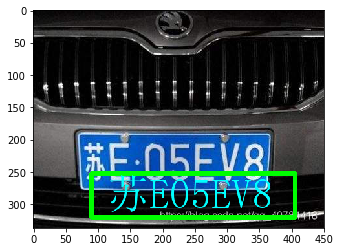

In [110]:
from PIL import ImageFont, ImageDraw, Image

height,weight = origin_image.shape[0:2]
print(height)
print(weight)

image_1 = origin_image.copy()
cv2.rectangle(image_1, (int(0.2*weight), int(0.75*height)), (int(weight*0.9), int(height*0.95)), (0, 255, 0), 5)

#设置需要显示的字体
fontpath = "font/simsun.ttc"
font = ImageFont.truetype(fontpath,64)
img_pil = Image.fromarray(image_1)
draw = ImageDraw.Draw(img_pil)
#绘制文字信息
draw.text((int(0.2*weight)+25, int(0.75*height)),  "".join(result), font = font, fill = (255, 255, 0))
bk_img = np.array(img_pil)
print(result)
print( "".join(result))
plt_show0(bk_img)